<a href="https://colab.research.google.com/github/lorrespz/Image_classification_collection/blob/main/Siamese_Network_for_Facial_Recognition_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese network for facial recognition with Yale face dataset


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

In [7]:
import tensorflow as tf
from keras.preprocessing import image

# Load the dataset

In [8]:
#https://www.kaggle.com/datasets/olgabelitskaya/yale-face-database/data
#dataset downloaded from Kaggle url above
from google.colab import files
yaleface = files.upload()

Saving Yalefaces.zip to Yalefaces.zip


In [9]:
!unzip Yalefaces

Archive:  Yalefaces.zip
  inflating: Readme.txt              
  inflating: data/Readme.txt         
  inflating: data/subject01.centerlight  
  inflating: data/subject01.glasses  
  inflating: data/subject01.happy    
  inflating: data/subject01.leftlight  
  inflating: data/subject01.noglasses  
  inflating: data/subject01.normal   
  inflating: data/subject01.rightlight  
  inflating: data/subject01.sad      
  inflating: data/subject01.sleepy   
  inflating: data/subject01.surprised  
  inflating: data/subject01.wink     
  inflating: data/subject02.centerlight  
  inflating: data/subject02.glasses  
  inflating: data/subject02.happy    
  inflating: data/subject02.leftlight  
  inflating: data/subject02.noglasses  
  inflating: data/subject02.normal   
  inflating: data/subject02.rightlight  
  inflating: data/subject02.sad      
  inflating: data/subject02.sleepy   
  inflating: data/subject02.surprised  
  inflating: data/subject02.wink     
  inflating: data/subject03.centerligh

In [10]:
files = glob('subject*')

In [11]:
N = len(files)
N

165

In [12]:
np.random.shuffle(files)

In [13]:
H, W = 60, 80
def load_img(filepath):
  img = image.img_to_array(image.load_img(filepath, target_size = [H,W])).astype('uint8')
  return img

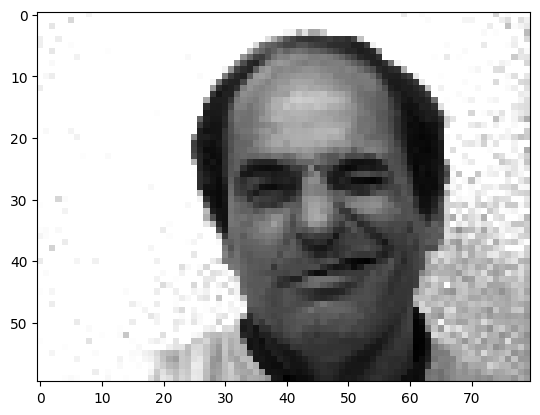

In [14]:
# Look at an img
img = load_img(np.random.choice(files))
plt.imshow(img)
plt.show()

In [15]:
img.shape, img.max()

((60, 80, 3), 255)

In [16]:
#the image is stored as color image, but it's grayscale
#this can be verified by looking at the 3 color channels (which are all equal)
np.array_equal(img[:,:,0],img[:,:,1]), np.array_equal(img[:,:,1],img[:,:,2])

(True, True)

In [17]:
def to_grayscale(img):
  return img.mean(axis = -1)

In [18]:
# Load images as arrays
shape = (N,H,W)
images = np.zeros(shape)
for i, f in enumerate(files):
  img = to_grayscale(load_img(f))/255
  images[i] = img

#make the labels
labels = np.zeros(N)
for i, f in enumerate(files):
  subject_num = f.split('.',1)[0]

  idx = int(subject_num.replace('subject', '')) -1
  labels[i] = idx

In [26]:
label_count = Counter(labels)
label_count

Counter({0.0: 11,
         9.0: 11,
         4.0: 11,
         13.0: 11,
         12.0: 11,
         3.0: 11,
         10.0: 11,
         11.0: 11,
         5.0: 11,
         6.0: 11,
         7.0: 11,
         14.0: 11,
         1.0: 11,
         8.0: 11,
         2.0: 11})

# Splitting the data into train and test

In [22]:
unique_labels = set(label_count.keys())
unique_labels

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0}

In [23]:
n_subjects = len(label_count)
n_test = 3*n_subjects
n_train = N - n_test
n_test, n_train

(45, 120)

In [34]:
#Initialize arrays to hold train and test images
train_images = np.zeros([n_train] + list(img.shape))
train_labels = np.zeros(n_train)
test_images = np.zeros([n_test] + list(img.shape))
test_labels = np.zeros(n_test)

In [31]:
list(zip(images, labels))[0]

(array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 0.93333333, 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]]),
 0.0)

In [35]:
#Fill up the arrays above that we just initialized
count_so_far = {}
train_idx = 0
test_idx = 0

for img, label in zip(images, labels):
  count_so_far[label] = count_so_far.get(label,0) +1
  if count_so_far[label] >3:
    #this subject has already 3 images, add the rest to train
    train_images[train_idx] = img
    train_labels[train_idx] = label
    train_idx+=1

  else:
    #add the first 3 images to test
    test_images[test_idx] = img
    test_labels[test_idx] = label
    test_idx +=1


In [38]:
train_images.shape, test_images.shape

((120, 60, 80), (45, 60, 80))

# Converting data into pairs

Recall that what we want to feed into the network is a pair of images together with the label (match/non-match). So, the data structure that we want to create consists of pairs of indexes that are sorted into the category of 'match' and 'non-match'.

In [39]:
#create label2idx mapping for easy access
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
  if label not in train_label2idx:
    train_label2idx[label] = [i]
  else:
    train_label2idx[label].append(i)

for i, label in enumerate(test_labels):
  if label not in test_label2idx:
    test_label2idx[label] = [i]
  else:
    test_label2idx[label].append(i)